## Background

The data set contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. We are going toidentify high-value customers by using different segmentation methods.

## Import Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

import os


## Load Data

In [2]:
df = pd.read_excel('Online Retail.xlsx')

## EDA

Let's check the first 5 rows of the data set.

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Below is the description of each column,

| Variable Name | Description|
| --- | --- |
| InvoiceNo | a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation|
| StockCode | an integral number uniquely assigned to each distinct product |
| Description | product name |
| Quantity | the quantities of each product (item) per transaction |
| InvoiceDate | the day and time when each transaction was generated |
| UnitPrice | product price per unit |
| CustomerID | an integral number uniquely assigned to each customer |
| Country | the name of the country where each customer resides |

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


There are null values in the columns "Description" and "CustomerID". 

In [5]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


Transactions with negative values of Quantity and UnitPrice need further investigation. Next, let check the data quality by checking the record count of each month.

In [6]:
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df['YearMonth'] = df['InvoiceDate'].dt.strftime('%Y-%m')

In [7]:
monthly_volume = df['YearMonth'].value_counts().sort_index().to_frame('Count').reset_index().rename(columns={'index': 'Value'})
monthly_volume

,YearMonth,Count
0,2010-12,42481
1,2011-01,35147
2,2011-02,27707
3,2011-03,36748
4,2011-04,29916
5,2011-05,37030
6,2011-06,36874
7,2011-07,39518
8,2011-08,35284
9,2011-09,50226


<Axes: xlabel='YearMonth', ylabel='Count'>

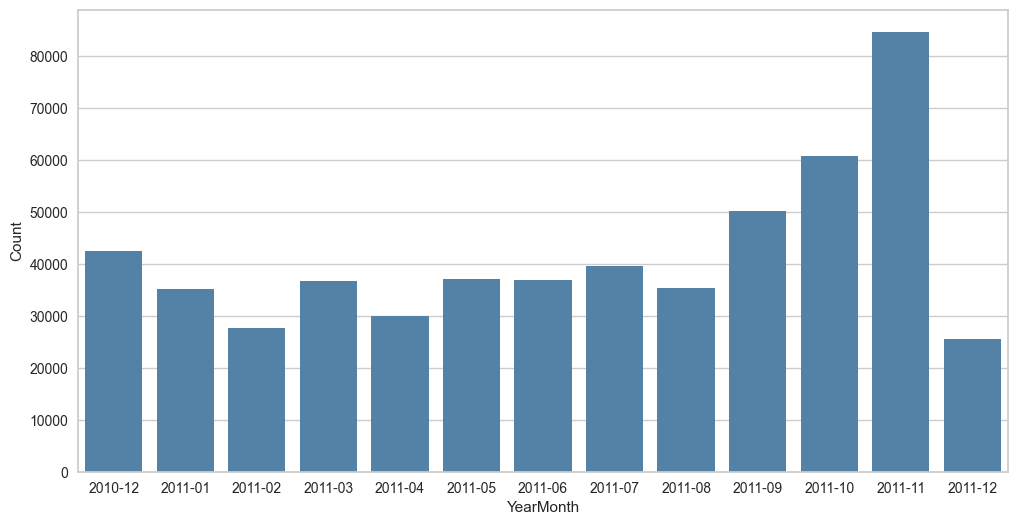

In [8]:
plt.figure(figsize=(12,6))
sns.barplot(x=monthly_volume['YearMonth'], y=monthly_volume['Count'],color='steelblue')

A sudden increase of transaction are observed in the months 2011-09 to 2011-11. Let's investigate more on this observation.

In [9]:
df.groupby('YearMonth').nunique().sort_index()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear
YearMonth,,,,,,,,,
2010-12,2025,2822,2760,206,1770,295,948,24,1
2011-01,1476,2645,2566,175,1349,330,783,24,1
2011-02,1393,2431,2372,167,1311,295,798,24,1
2011-03,1983,2562,2506,241,1808,327,1020,24,1
2011-04,1744,2558,2456,203,1540,272,899,28,1
2011-05,2162,2505,2480,206,1931,331,1079,21,1
2011-06,2012,2672,2639,216,1825,340,1051,26,1
2011-07,1927,2748,2693,191,1735,327,993,24,1
2011-08,1737,2614,2609,229,1608,301,980,25,1


From the table above, we can see that the sudden increase of stock transactions of 2011-09 to 2011-11 mainly from the increase of customers.

Next, let's check the missing values in this data set.

In [10]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
InvoiceYear         0
YearMonth           0
dtype: int64

In [11]:
df[df['Description'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,YearMonth
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,2010,2010-12
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,2010,2010-12
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,2010,2010-12
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,2010,2010-12
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,2010,2010-12
...,...,...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2011-12-07 18:26:00,0.0,NaN,United Kingdom,2011,2011-12
535326,581203,23406,NaN,15,2011-12-07 18:31:00,0.0,NaN,United Kingdom,2011,2011-12
535332,581209,21620,NaN,6,2011-12-07 18:35:00,0.0,NaN,United Kingdom,2011,2011-12
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom,2011,2011-12


In [12]:
df[df['Description'].isnull()]['UnitPrice'].value_counts()

UnitPrice
0.0    1454
Name: count, dtype: int64

The records with null Description also have Unit Price 0.0

In [13]:
df['CustomerID'] = df['CustomerID'].astype('str')

In [14]:
df['CustomerID'].value_counts()

CustomerID
nan        135080
17841.0      7983
14911.0      5903
14096.0      5128
12748.0      4642
            ...  
13270.0         1
17763.0         1
17291.0         1
15668.0         1
15562.0         1
Name: count, Length: 4373, dtype: int64

There are 135,080 transactions with null CustomerID. Since we need the customer information after the segmentation. If the null CustomerID cannot be resolved, they have to be removed from the analysis.

In [15]:
df[df['CustomerID']=='nan']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,YearMonth
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,nan,United Kingdom,2010,2010-12
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,nan,United Kingdom,2010,2010-12
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,nan,United Kingdom,2010,2010-12
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,nan,United Kingdom,2010,2010-12
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,nan,United Kingdom,2010,2010-12
...,...,...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,nan,United Kingdom,2011,2011-12
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,nan,United Kingdom,2011,2011-12
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,nan,United Kingdom,2011,2011-12
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,nan,United Kingdom,2011,2011-12


In [16]:
df['Country'].value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


In [17]:
df[df['CustomerID']=='nan']['Country'].value_counts()

Country
United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Bahrain                2
Name: count, dtype: int64

In [18]:
df[df['CustomerID']=='nan']['YearMonth'].value_counts().sort_index()

YearMonth
2010-12    15631
2011-01    13235
2011-02     7344
2011-03     8926
2011-04     6718
2011-05     8122
2011-06     9038
2011-07    12016
2011-08     7622
2011-09     9404
2011-10    10047
2011-11    19113
2011-12     7864
Name: count, dtype: int64

The transactions with null CustomerID are speaded across each month rather than clutered within a particular time period. So we will remove these transactions as no customer infomation included.

In [19]:
df[df['Quantity']<=0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,YearMonth
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,2010,2010-12
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,2010,2010-12
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010,2010-12
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,2010-12
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,2010-12
...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,2011,2011-12
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,2011,2011-12
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,2011,2011-12
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,2011,2011-12


Transactions with negative Quantity have special pattern in the InvoiceNo. Let's dig into it.

In [20]:
df[df['Quantity']<=0]['InvoiceNo'].astype(str).str[0].value_counts()

InvoiceNo
C    9288
5    1336
Name: count, dtype: int64

In [21]:
df_inv = df[df['Quantity']<=0]
df_inv['InvoiceNo'] = df_inv['InvoiceNo'].astype(str)

Let's check if any finding from Description column.

In [22]:
print(df_inv[df_inv['InvoiceNo'].str.startswith('C')]['Description'].value_counts()[0:20].to_string())

Description
Manual                                244
REGENCY CAKESTAND 3 TIER              181
POSTAGE                               126
JAM MAKING SET WITH JARS               87
Discount                               77
SET OF 3 CAKE TINS PANTRY DESIGN       74
SAMPLES                                61
STRAWBERRY CERAMIC TRINKET BOX         55
ROSES REGENCY TEACUP AND SAUCER        54
RECIPE BOX PANTRY YELLOW DESIGN        47
WOOD 2 DRAWER CABINET WHITE FINISH     45
LUNCH BAG RED RETROSPOT                44
JUMBO BAG RED RETROSPOT                44
GREEN REGENCY TEACUP AND SAUCER        42
WHITE HANGING HEART T-LIGHT HOLDER     42
RED RETROSPOT CAKE STAND               42
SMALL GLASS HEART TRINKET POT          40
SET OF 3 REGENCY CAKE TINS             37
POPCORN HOLDER                         36
SILVER HANGING T-LIGHT HOLDER          35


In [23]:
print(df_inv[df_inv['InvoiceNo'].str.startswith('5')]['Description'].value_counts()[0:20].to_string())

Description
check                     120
damages                    45
damaged                    42
?                          41
sold as set on dotcom      20
Damaged                    14
thrown away                 9
Unsaleable, destroyed.      9
??                          7
wet damaged                 5
damages?                    5
ebay                        5
smashed                     4
missing                     3
wet pallet                  3
CHECK                       3
sold as 1                   2
incorrect stock entry.      2
crushed                     2
adjustment                  2


### Data Clean

For the analysis in this notebook, we focus on the transactions with positive Price and Quanity from a valid CustomerID. But, one can also includes the cancelled transactions if the frequency of the cancellations is taken into account.

In [24]:
df_clean = df[df['Quantity'] > 0]
df_clean = df_clean[df_clean['UnitPrice']>0]
df_clean = df_clean[df_clean['CustomerID']!='nan']

In [25]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  object        
 7   Country      397884 non-null  object        
 8   InvoiceYear  397884 non-null  int32         
 9   YearMonth    397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(6)
memory usage: 31.9+ MB


In [26]:
df_clean.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
InvoiceYear    0
YearMonth      0
dtype: int64

In [27]:
df_clean.describe()

,Quantity,InvoiceDate,UnitPrice,InvoiceYear
count,397884.000000,397884,397884.000000,397884.000000
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488,2010.934260
min,1.000000,2010-12-01 08:26:00,0.001000,2010.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,2011.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,2011.000000
75%,12.000000,2011-10-20 14:33:00,3.750000,2011.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,2011.000000
std,179.331775,NaN,22.097877,0.247828


In [28]:
df_clean['Country'].value_counts()

Country
United Kingdom          354321
Germany                   9040
France                    8341
EIRE                      7236
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45


In [29]:
print("Number of customers: ",len(df_clean['CustomerID'].unique()))
print("Number of stocks: ",len(df_clean['StockCode'].unique()))

Number of customers:  4338
Number of stocks:  3665


In [30]:
monthly_volume = df_clean['YearMonth'].value_counts().sort_index().to_frame('Count').reset_index().rename(columns={'index': 'Value'})
monthly_volume

,YearMonth,Count
0,2010-12,26157
1,2011-01,21229
2,2011-02,19927
3,2011-03,27175
4,2011-04,22642
5,2011-05,28320
6,2011-06,27185
7,2011-07,26825
8,2011-08,27007
9,2011-09,40028


<Axes: xlabel='YearMonth', ylabel='Count'>

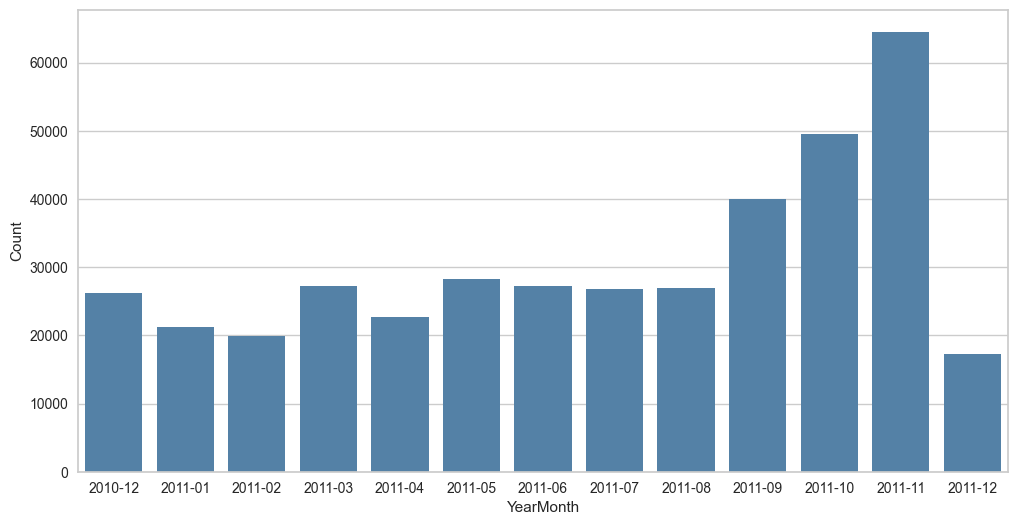

In [31]:
plt.figure(figsize=(12,6))
sns.barplot(x=monthly_volume['YearMonth'], y=monthly_volume['Count'],color='steelblue')

## Clustering

Now we are ready for the customer segmentation. We will start from feature engineering to create some important features for the clustering process. A good starting point is to define features using the RFM approach. 

RFM is a method used for analyzing customer value and segmenting customers which is commonly used in database marketing and direct marketing [1]. RFM stands for the three dimensions:
- Recency – How recently did the customer purchase?
- Frequency – How often do they purchase?
- Monetary Value – How much do they spend? 

In [32]:
anchorDate = dt.datetime(2011,12,10)
df_clean['TotalValue'] = df_clean['Quantity']*df_clean['UnitPrice']
rfm=df_clean.groupby('CustomerID').agg({'InvoiceDate': lambda x: (anchorDate-x.max()).days,
                                       'InvoiceNo': lambda x: len(x),
                                       'TotalValue': lambda x: x.sum()})
rfm= rfm.rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalValue':'Monetary'})

In [33]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


Let's check the distribution of these features.

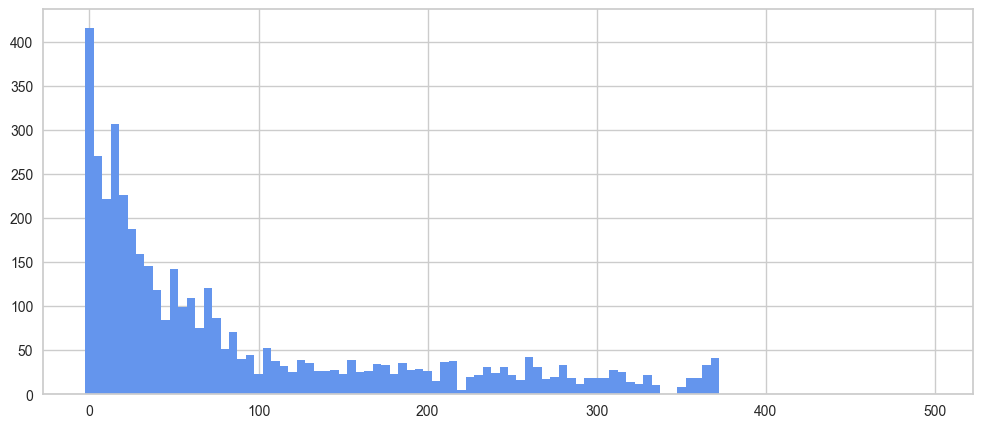

In [34]:
plt.figure(figsize = (12,5))
hist = plt.hist(rfm['Recency'], bins=100, range=[0,500], align='left', color='cornflowerblue')

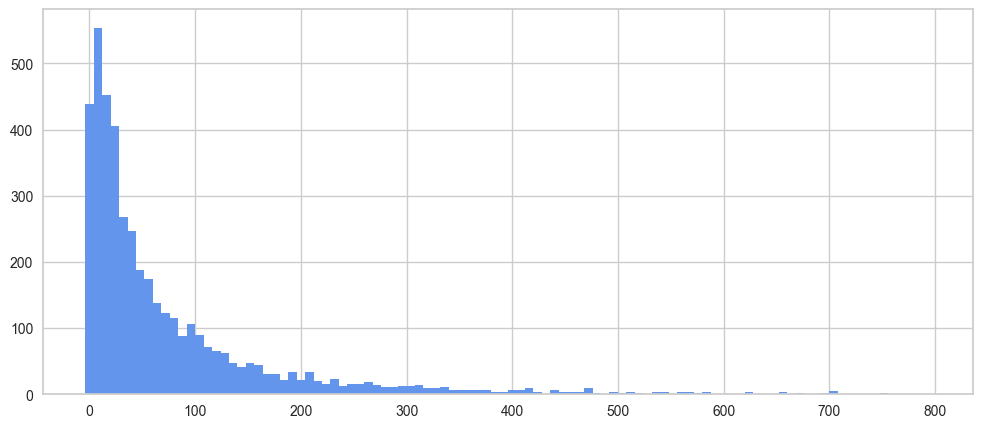

In [35]:
plt.figure(figsize = (12,5))
hist = plt.hist(rfm['Frequency'], bins=100, range=[0,800], align='left', color='cornflowerblue')

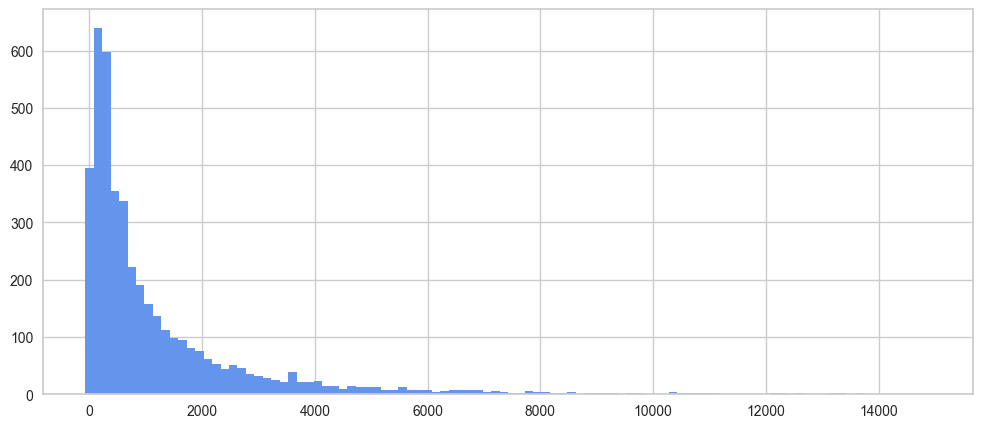

In [36]:
plt.figure(figsize = (12,5))
hist = plt.hist(rfm['Monetary'], bins=100, range=[0,15000], align='left', color='cornflowerblue')

All three features are right-skewed, with particularly large values in Frequency and Monetary. When using distance-based models such as KMeans, these large values can skew the model results, as KMeans relies on Euclidean distance. A good practice is to apply a logarithmic transformation to these features.

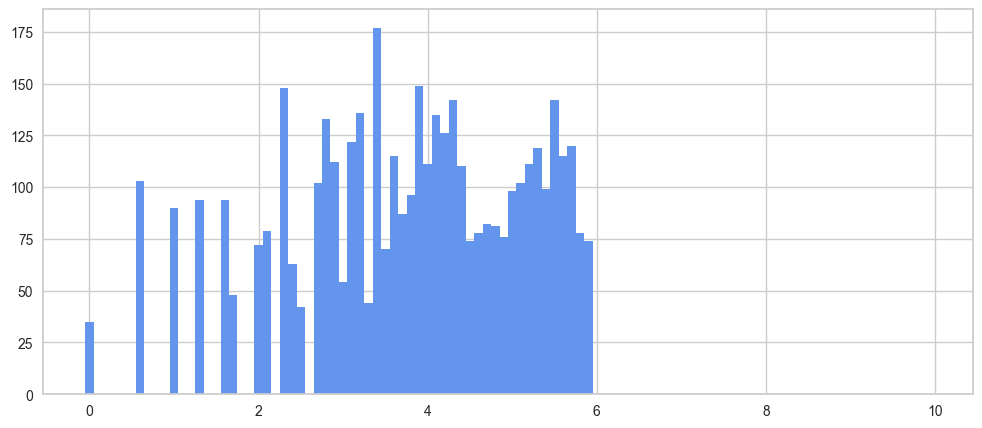

In [37]:
plt.figure(figsize = (12,5))
hist = plt.hist(np.log(rfm['Recency']+1), bins=100, range=[0,10], align='left', color='cornflowerblue')

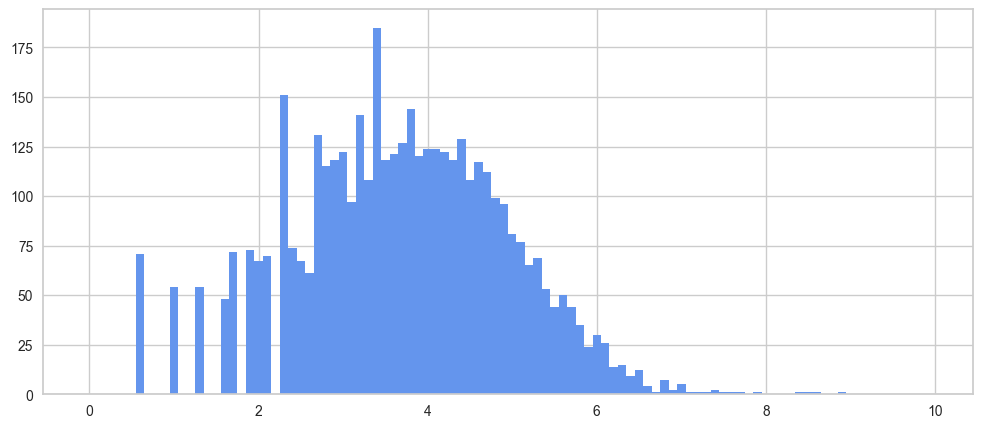

In [38]:
plt.figure(figsize = (12,5))
hist = plt.hist(np.log(rfm['Frequency']+1), bins=100, range=[0,10], align='left', color='cornflowerblue')

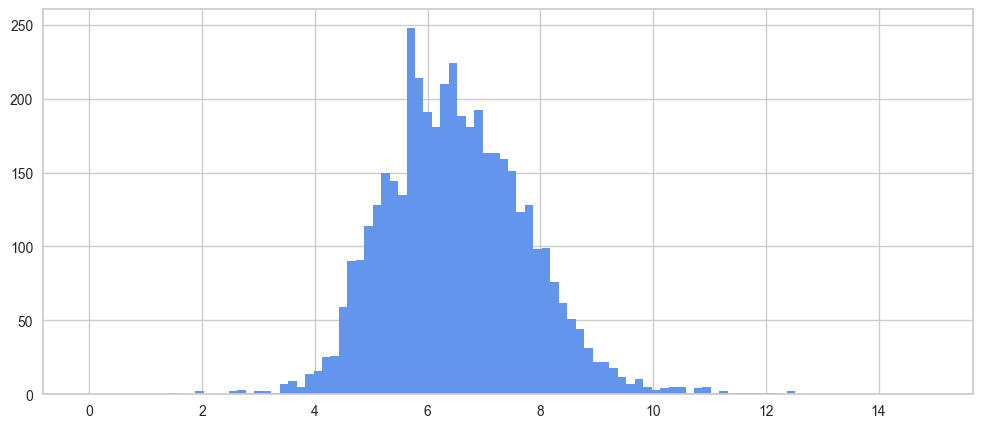

In [39]:
plt.figure(figsize = (12,5))
hist = plt.hist(np.log(rfm['Monetary']+1), bins=100, range=[0,15], align='left', color='cornflowerblue')

After taking the logarithm, the distributions are close to normal and their scales are the same.

In [40]:
rfm['log_Recency'] = np.log1p(rfm['Recency'])
rfm['log_Frequency'] = np.log1p(rfm['Frequency'])
rfm['log_Monetary'] = np.log1p(rfm['Monetary'])

In [41]:
rfm.head()

,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary
CustomerID,,,,,,
12346.0,325,1,77183.60,5.786897,0.693147,11.253955
12347.0,2,182,4310.00,1.098612,5.209486,8.368925
12348.0,75,31,1797.24,4.330733,3.465736,7.494564
12349.0,18,73,1757.55,2.944439,4.304065,7.472245
12350.0,310,17,334.40,5.739793,2.890372,5.815324


In [42]:
rfm.describe()

,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,92.059474,91.720609,2054.266460,3.801055,3.737143,6.593627
std,100.012264,228.785094,8989.230441,1.383620,1.250560,1.257578
min,0.000000,1.000000,3.750000,0.000000,0.693147,1.558145
25%,17.000000,17.000000,307.415000,2.890372,2.890372,5.731446
50%,50.000000,41.000000,674.485000,3.931826,3.737670,6.515431
75%,141.750000,100.000000,1661.740000,4.961090,4.615121,7.416222
max,373.000000,7847.000000,280206.020000,5.924256,8.968014,12.543284


It depends on the business scenarios to determine the number of segmentations. We start from KMeans to identify the number of classes.

### Kmeans

K-Means is a centroid-based clustering algorithm that partitions data into k clusters based on their distance from the mean (centroid) of each cluster.

In [43]:
#scaler = MinMaxScaler((0, 1))
#df_rfm = scaler.fit_transform(rfm.loc[:,['log_Recency','log_Frequency','log_Monetary']])
df_rfm=np.array(rfm.loc[:,['log_Recency','log_Frequency','log_Monetary']])

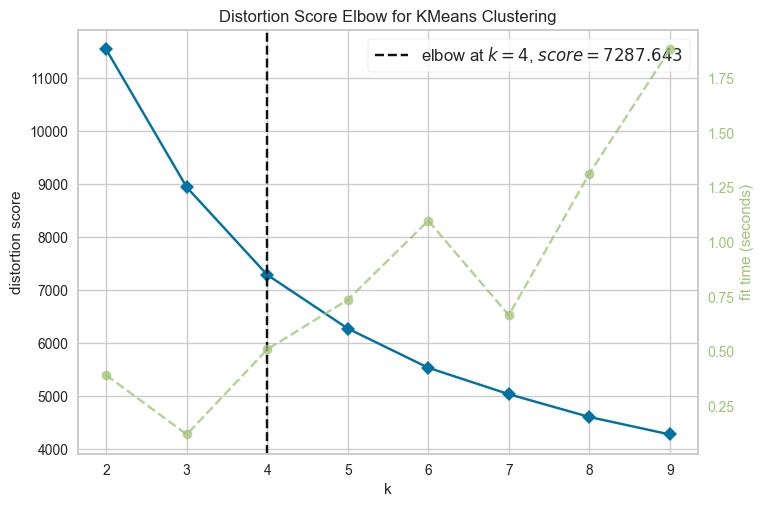

In [44]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))

visualizer.fit(df_rfm) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

In [45]:
km_mdl = KMeans(n_clusters=4, random_state=32)

km = km_mdl.fit_predict(df_rfm)

In [46]:
np.unique(km)

array([0, 1, 2, 3], dtype=int32)

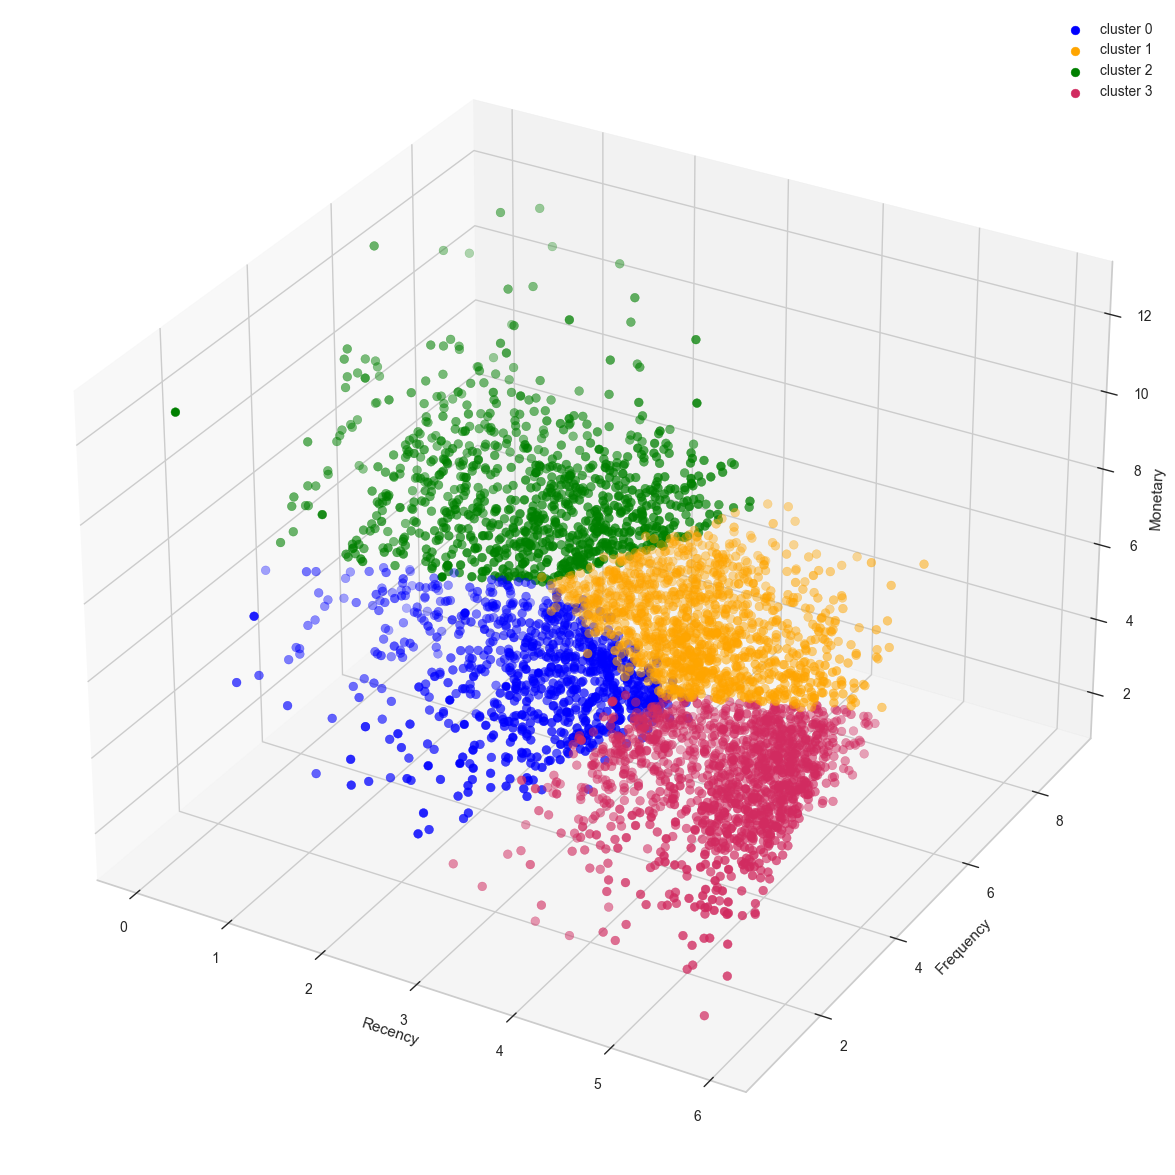

In [47]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_rfm[km == 0,0],df_rfm[km == 0,1],df_rfm[km == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(df_rfm[km == 1,0],df_rfm[km == 1,1],df_rfm[km == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(df_rfm[km == 2,0],df_rfm[km == 2,1],df_rfm[km == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(df_rfm[km == 3,0],df_rfm[km == 3,1],df_rfm[km == 3,2], s = 40 , color = '#D12B60', label = "cluster 3")
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.legend()
plt.show()

Below is the code of creating an interactive 3D plot.

In [48]:
colors = ['blue', 'orange', 'green', '#D12B60']

# Create a 3D scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=df_rfm[km == 0,0], y=df_rfm[km == 0,1], z=df_rfm[km == 0,2], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=df_rfm[km == 1,0], y=df_rfm[km == 1,1], z=df_rfm[km == 1,2], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=df_rfm[km == 2,0], y=df_rfm[km == 2,1], z=df_rfm[km == 2,2],
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))
fig.add_trace(go.Scatter3d(x=df_rfm[km == 3,0], y=df_rfm[km == 3,1], z=df_rfm[km == 3,2],
                           mode='markers', marker=dict(color=colors[3], size=5, opacity=0.4), name='Cluster 3'))

fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='Recency'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='Frequency'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='Monetary'),
    ),
    width=900,
    height=800
)
fig.show()

The figure above shows the 4 clusters from KMeans. The results seems promising: Cluster 2 (green) is the class with small Receny, high Frequency and high Monetary, while Cluster 0 (blue) is the class with large Receny, low Frequency and small Monetary. We will check more detials later.

### RFM

To create customer segments using our RFM model, we can use quartiles, which divide the data into four sections with an equal number of observations. Let's see the results below.

In [49]:
r_quarters = rfm['Recency'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
f_quarters = rfm['Frequency'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
m_quarters = rfm['Monetary'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
quartile_spread = pd.DataFrame(list(zip(r_quarters, f_quarters, m_quarters)), 
                      columns=['Q_Recency','Q_Frequency', 'Q_Monetary'],
                     index = ['min', 'first_part','second_part','third_part', 'max'])
quartile_spread

,Q_Recency,Q_Frequency,Q_Monetary
min,0.00,1.0,3.750
first_part,17.00,17.0,307.415
second_part,50.00,41.0,674.485
third_part,141.75,100.0,1661.740
max,373.00,7847.0,280206.020


In [50]:
rfm['r_score'] = pd.cut(rfm['Recency'], bins=r_quarters, labels=[4,3,2,1],include_lowest=True)
rfm['f_score'] = pd.cut(rfm['Frequency'], bins=f_quarters, labels=[1,2,3,4],include_lowest=True)
rfm['m_score'] = pd.cut(rfm['Monetary'], bins=m_quarters, labels=[1,2,3,4],include_lowest=True)
rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)

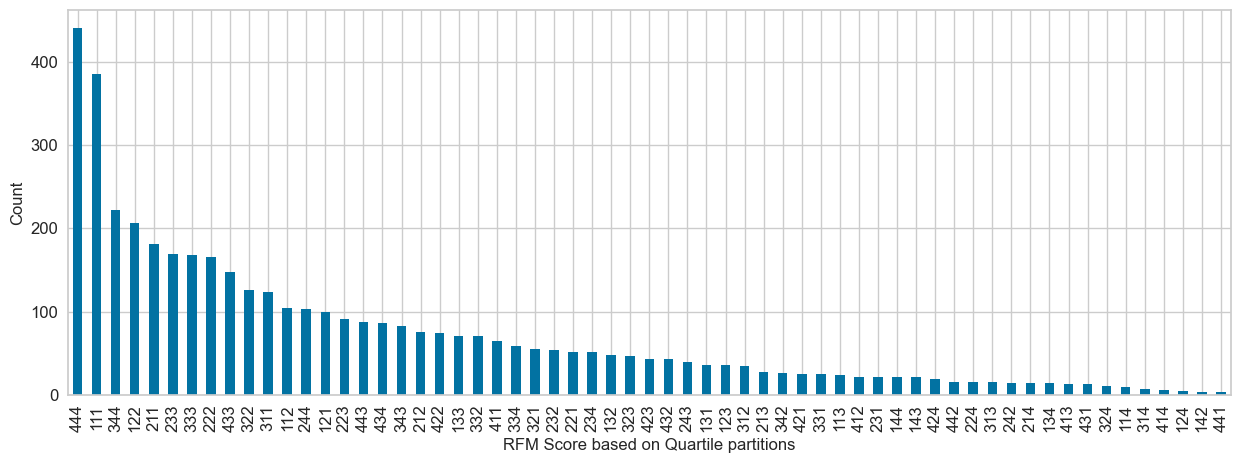

In [51]:
ax = rfm['rfm_score'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Score based on Quartile partitions", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

The largest segment here is the most valuable customers as shown above.

In [52]:
rfm[rfm['rfm_score']=='444'].sort_values('Recency',ascending=False)

,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary,r_score,f_score,m_score,rfm_score
CustomerID,,,,,,,,,,
16985.0,17,120,5464.12,2.890372,4.795791,8.606141,4,4,4,444
17659.0,17,158,2999.46,2.890372,5.068904,8.006521,4,4,4,444
16655.0,17,261,3794.52,2.890372,5.568345,8.241577,4,4,4,444
16633.0,17,152,2883.10,2.890372,5.030438,7.966968,4,4,4,444
14505.0,17,799,5905.64,2.890372,6.684612,8.683832,4,4,4,444
...,...,...,...,...,...,...,...,...,...,...
17581.0,0,440,11045.04,0.000000,6.089045,9.309827,4,4,4,444
13113.0,0,200,12245.96,0.000000,5.303305,9.413033,4,4,4,444
16626.0,0,179,4413.10,0.000000,5.192957,8.392559,4,4,4,444


### Aggregate the RFM results

In [53]:
agg_map = {
    r'444': '01_core',
    r'[3-4][3-4][3-4]': '02_loyal_large',
    r'[3-4][3-4][1-2]': '02_loyal_small',
    r'[3-4][1-2][3-4]': '03_new_large',
    r'[3-4][1-2][1-2]': '03_new_small',
    r'[1-2][3-4][3-4]': '04_lost_loyal_large',
    r'[1-2][3-4][1-2]': '04_lost_loyal_small',
    r'[1-2][1-2][3-4]': '05_promising',
    r'[1-2][1-2][1-2]': '06_low_priority',
}

rfm['RFM_segment'] = rfm['rfm_score'].replace(agg_map, regex=True)

rfm.reset_index()
rfm.head()

,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary,r_score,f_score,m_score,rfm_score,RFM_segment
CustomerID,,,,,,,,,,,
12346.0,325,1,77183.60,5.786897,0.693147,11.253955,1,1,4,114,05_promising
12347.0,2,182,4310.00,1.098612,5.209486,8.368925,4,4,4,444,01_core
12348.0,75,31,1797.24,4.330733,3.465736,7.494564,2,2,4,224,05_promising
12349.0,18,73,1757.55,2.944439,4.304065,7.472245,3,3,4,334,02_loyal_large
12350.0,310,17,334.40,5.739793,2.890372,5.815324,1,1,2,112,06_low_priority


In [54]:
rfm[["RFM_segment","Recency","Frequency","Monetary"]].groupby(["RFM_segment"]).agg(["mean","count"])

Recency         Frequency           Monetary      
                           mean count        mean count         mean count
RFM_segment                                                               
01_core                6.629545   440  377.697727   440  9427.541159   440
02_loyal_large        21.907386   853  132.980070   853  2643.434491   853
02_loyal_small        22.299492   197   79.827411   197   441.755635   197
03_new_large          20.515528   161   25.919255   161  2680.389876   161
03_new_small          24.483810   525   19.150476   525   323.418419   525
04_lost_loyal_large  114.077393   491  101.790224   491  1876.588862   491
04_lost_loyal_small  164.207865   178   70.331461   178   403.648258   178
05_promising         136.227679   224   23.723214   224  2042.523795   224
06_low_priority      190.263199  1269   16.154452  1269   291.014202  1269

In [55]:
rfm['KMean_Segment'] = km

In [56]:
rfm[["KMean_Segment","Recency","Frequency","Monetary"]].groupby(["KMean_Segment"]).agg(["mean","count"])

Recency         Frequency           Monetary      
                     mean count        mean count         mean count
KMean_Segment                                                       
0               23.888889   846   29.871158   846   469.585095   846
1               84.263117  1296   85.048611  1296  1590.502425  1296
2               10.399777   898  269.024499   898  6731.113163   898
3              200.770416  1298   16.029276  1298   314.567143  1298

From the table above, the results from KMeans can be interpreted as:

- Cluster 1: Core customers
- Cluster 2: Loyal customers
- Cluster 0: New customers
- Cluster 3: Low priority

This is consistent with the figure of the clusters we previously saw.

## Model Comparison

In [57]:
rfm['KMean_Segment'] = rfm['KMean_Segment'].astype(str)
km_map = {
    r'3': 'Low priority',
    r'2': 'Loyal',
    r'0': 'New',
    r'1': 'Core',
}

rfm['KMeans_seg_trans'] = rfm['KMean_Segment'].replace(km_map, regex=True)

In [58]:
rfm.head()

,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary,r_score,f_score,m_score,rfm_score,RFM_segment,KMean_Segment,KMeans_seg_trans
CustomerID,,,,,,,,,,,,,
12346.0,325,1,77183.60,5.786897,0.693147,11.253955,1,1,4,114,05_promising,1,Core
12347.0,2,182,4310.00,1.098612,5.209486,8.368925,4,4,4,444,01_core,2,Loyal
12348.0,75,31,1797.24,4.330733,3.465736,7.494564,2,2,4,224,05_promising,1,Core
12349.0,18,73,1757.55,2.944439,4.304065,7.472245,3,3,4,334,02_loyal_large,1,Core
12350.0,310,17,334.40,5.739793,2.890372,5.815324,1,1,2,112,06_low_priority,3,Low priority


In [59]:
rfm[["KMeans_seg_trans",'RFM_segment']].groupby(["KMeans_seg_trans","RFM_segment"])["RFM_segment"].agg(['count'])

count
KMeans_seg_trans RFM_segment               
Core             02_loyal_large         377
                 02_loyal_small          53
                 03_new_large            36
                 03_new_small             5
                 04_lost_loyal_large    489
                 04_lost_loyal_small    115
                 05_promising           153
                 06_low_priority         68
Low priority     03_new_small            29
                 04_lost_loyal_small     55
                 05_promising            66
                 06_low_priority       1148
Loyal            01_core                440
                 02_loyal_large         421
                 02_loyal_small          11
                 03_new_large            24
                 04_lost_loyal_large      2
New              02_loyal_large          55
                 02_loyal_small         133
                 03_new_large           101
                 03_new_small           491
                 04_lost_loyal_small      8
                 05_promising             5
                 06_low_priority         53

## Conclusion

In our analysis, we applied both KMeans clustering and RFM segmentation methods to the retail dataset to identify distinct customer segments. The results revealed a significant overlap between the customer segments identified by both methods. This overlap suggests that the segments derived from the KMeans clustering align closely with those defined by RFM analysis, indicating consistency and reliability in the segmentation process. 